In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import re
import time
from scripts import *
import scipy.linalg as la

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split as tts, cross_val_score
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve

from plotMatriz import plotMatriz

### Texto Stemmed

In [2]:
stemmed_data_path = 'Dados/stemsnowball.p'

# Logistic Regression
## Binary Case

In [3]:
tfidf_bin_path  = 'tfidf/tfidf_bin.p'
final_tfidf_bin     = 'tfidf/tfidf_binario.p'

#### Funcoes auxiliares para testar patters, mindf, ngram, C e penalty tudo ao mesmo tempo

In [4]:
def results_scores(tipo, X1train, X1val, X2, y1train, y1val, y2, dicionario_size, par, ponto=(0,0)):
    # tipos -> 'cv', 'n_erros', 'pr'
    # par = (penalty, C)
    # print('A treinar o modelo com os melhores parâmetros encontrados', tipo)
    # print('Dimensão do vocabulário utilizado:', dicionario_size)
    logReg = LogisticRegression(penalty=par[0], solver='liblinear', C=par[1], max_iter=5000, tol=1e-2).fit(X1train, y1train)
    
    #scoreTrain = logReg.score(X1train, y1train)*100
    scoreVal   = logReg.score(X1val, y1val)*100
    #scoreTest  = logReg.score(X2, y2)*100
    
    # print('Acertos (treino) ', (scoreTrain))
    # print('Acertos (validação) ',(scoreVal))
    # print('Acertos (teste) ', (scoreTest))
    # print('Penalty = ', par[0] )
    # print('C = ', par[1],'\n')
    
    # y2e = logReg.predict(X2) # classe estimada
    # CM = confusion_matrix(y2, y2e) # calculo da matriz de confusão
        
    # print('Matriz de Confusão (teste)(nº erros = '+ str(np.sum(y2!=y2e)) +' ):\n', CM)
    
    return scoreVal

In [5]:
def binary(patterns, min_df, ngram_range):
    D = pickle.load(open(stemmed_data_path, 'rb'))
    Docs = D['Docs']
    yB = D['y']

    yB[yB < 5] = 0
    yB[yB > 6] = 1  
      
    #train test split
    Docs1, Docs2, y1, y2 = tts(Docs, yB, test_size=1/4, stratify=yB,random_state=42) # 1/4 dos dados totais para teste
    Docs1train, Docs1val, y1train, y1val = tts(Docs1, y1, test_size=1/3, stratify=y1,random_state=42) # dados de validação
    
    #vetorizar texto
    tfidf = TfidfVectorizer(min_df = min_df, token_pattern=patterns, ngram_range=ngram_range).fit(Docs1train)

    #criação do dicionário
    TF_model = {'tfidf' : tfidf}

    #dump dos dados
    pickle.dump(TF_model, open(tfidf_bin_path, 'wb'))
    
    #load dos dados
    tfidf = pickle.load(open(tfidf_bin_path, 'rb'))['tfidf']

    tokens = tfidf.get_feature_names()
    dicionario_size = len(tokens)
    
    X1      = tfidf.transform(Docs1)
    X1train = tfidf.transform(Docs1train)
    X1val   = tfidf.transform(Docs1val)
    X2      = tfidf.transform(Docs2)

    array_cs = [0.01, 0.1, 1, 5, 10]
    array_ps = ['l1', 'l2'] # l1 -> Lasso, l2 -> Ridge
    
    bestScore   = 0
    bestCV = 0 # sobreaprendizagem
    
    par   = None
    parB  = None
    parC  = None
    parD  = None

    ideal = np.array([[1.0], 
                      [1.0]])
    dist_min = 1
    ponto    = None
    
    nErros_min = 50000 # número de erros minimo

    for p in array_ps:
        for c in array_cs:
            # com cross validation no conjunto de treino
            logReg = LogisticRegression(penalty=p, solver='liblinear', C=c, max_iter=5000, tol=1e-2, random_state=42)
            scoreVal  = np.mean(cross_val_score(logReg, X1, y1, cv=5))
            
            # semelhante ao score mas olhando para o número absoluto de erros
            logReg.fit(X1train, y1train)
            y1valE  = logReg.predict(X1val)
            num_erros = np.sum(y1val!=y1valE)
            
            # tendo em conta a descrepância entre os resultados no treino e na validação
            score   = logReg.score(X1val, y1val)
            
            # escolher com base no ponto da curva precision_recall mais proximo de (1,1) que minimiza o erro global
            prec, rec, limiar = precision_recall_curve(y1val, y1valE)
            pontos = np.array([prec, rec])
            
            dists   = np.sqrt(np.sum((pontos-ideal)**2, axis=0)) # calcular as distâncias com recurso à distância euclidiana
            
            idx_min = np.argmin(dists) #return o indice do menor valor do array
            dist    = dists[idx_min] # menor distância
            ponto_ideal = pontos[:, idx_min] # guarda o ponto ideal
            
            if dist <= dist_min:
                ponto = ponto_ideal
                parB = (p, c) 
            if score >= bestScore:
                bestScore = score
                par = (p, c)    
            if num_erros <= nErros_min:
                nErros_min = num_erros
                parC = (p, c)
            if scoreVal >= bestCV:
                bestCV = scoreVal
                parD = (p, c)
        
    score1 = results_scores('Melhor Score',X1train, X1val, X2, y1train, y1val, y2, dicionario_size, par)
    score2 = results_scores('Menor número de erros',X1train, X1val, X2, y1train, y1val, y2, dicionario_size, parC)
    score3 = results_scores('Melhor precisão',X1train, X1val, X2, y1train, y1val, y2, dicionario_size, parB, ponto=ponto)
    score4 = results_scores('Melhor CrossVal', X1train, X1val, X2, y1train, y1val, y2, dicionario_size, parD)
    
    scoreAvg = np.mean(np.array([score1, score2, score3, score4]))
    print('Final Score ', round(scoreAvg,3))
    print('Dictionary size ', dicionario_size)
    return scoreAvg, dicionario_size

#### Combinacoes ponderadas

In [6]:
patterns     = [r'\b\w\w+\b', r'\b\w\w\w+\b', r'\b\w\w\w\w+\b'] 
min_dfs      = [2,3,4,5]
ngram_ranges = [(1,1), (1,2), (1,3)]

- Estudar o token_pattern e do ngram_range no tamanho do Vocabulário e o desempenho do Classificador

In [7]:
iniciar = time.time()

combinacoes = [(tp, df, gram) for tp in patterns for df in min_dfs  for gram in ngram_ranges]
resultados  = [binary(tp, df, gram)  for (tp, df, gram)  in combinacoes]

acabar = time.time()

C:\Users\amvlf\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Final Score  89.376
Dictionary size  29274


C:\Users\amvlf\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Final Score  90.824
Dictionary size  391951


C:\Users\amvlf\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Final Score  90.88
Dictionary size  863393


C:\Users\amvlf\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Final Score  89.354
Dictionary size  23342


C:\Users\amvlf\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Final Score  90.8
Dictionary size  241710


C:\Users\amvlf\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Final Score  90.92
Dictionary size  464542


C:\Users\amvlf\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Final Score  89.274
Dictionary size  20105


C:\Users\amvlf\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Final Score  90.752
Dictionary size  178442


C:\Users\amvlf\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Final Score  90.992
Dictionary size  319293


C:\Users\amvlf\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Final Score  89.288
Dictionary size  17986


C:\Users\amvlf\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Final Score  90.776
Dictionary size  143323


C:\Users\amvlf\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Final Score  91.016
Dictionary size  244678


C:\Users\amvlf\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Final Score  89.114
Dictionary size  28887


C:\Users\amvlf\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Final Score  90.688
Dictionary size  382877


C:\Users\amvlf\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Final Score  90.496
Dictionary size  725287


C:\Users\amvlf\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Final Score  89.008
Dictionary size  23008


C:\Users\amvlf\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Final Score  90.688
Dictionary size  226036


C:\Users\amvlf\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Final Score  90.736
Dictionary size  372643


C:\Users\amvlf\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Final Score  88.996
Dictionary size  19823


C:\Users\amvlf\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Final Score  90.688
Dictionary size  162854


C:\Users\amvlf\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Final Score  90.72
Dictionary size  250834


C:\Users\amvlf\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Final Score  88.978
Dictionary size  17738


C:\Users\amvlf\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Final Score  90.648
Dictionary size  128529


C:\Users\amvlf\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Final Score  90.768
Dictionary size  189664


C:\Users\amvlf\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Final Score  88.384
Dictionary size  27423


C:\Users\amvlf\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Final Score  89.728
Dictionary size  352353


C:\Users\amvlf\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Final Score  89.88
Dictionary size  503936


C:\Users\amvlf\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Final Score  88.31
Dictionary size  21822


C:\Users\amvlf\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Final Score  89.784
Dictionary size  193897


C:\Users\amvlf\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Final Score  89.804
Dictionary size  245097


C:\Users\amvlf\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Final Score  88.24
Dictionary size  18779


C:\Users\amvlf\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Final Score  89.736
Dictionary size  133383


C:\Users\amvlf\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Final Score  89.872
Dictionary size  161158


C:\Users\amvlf\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Final Score  88.292
Dictionary size  16777


C:\Users\amvlf\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Final Score  89.628
Dictionary size  101952


C:\Users\amvlf\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Final Score  89.722
Dictionary size  120045


#### Duracao do teste + dump de TODOS os resultados obtidos em pickle

In [8]:
resultados_tp_ngram_bin = 'Resultados/lr_r_tp_ngram_bin.p'

In [9]:
print('Duração do teste:', int((acabar-iniciar)//60), 'min :', int((acabar-iniciar)%60), 'seg')

score = [i[0] for i in resultados]
dicionario_size = [i[1] for i in resultados]

lido  = {'parametros': combinacoes,'vocabulario': dicionario_size,'score': score}

pickle.dump(lido, open(resultados_tp_ngram_bin, 'wb'))

Duração do teste: 49 min : 29 seg


#### Carregar dados de pickle para análise

In [10]:
dados = pickle.load(open(resultados_tp_ngram_bin,'rb'))

combinacoes = dados['parametros']
voc_size    = dados['vocabulario']
score       = dados['score']

#### Func auxiliar para plot de dados

In [11]:
def sort_array(combinacoes, alvo):
    indices = np.array([],dtype=object)
    for i in range(len(combinacoes)):
        if combinacoes[i][1] == alvo:
            indices   = np.append(indices,i)
    return np.asanyarray(indices)

In [12]:
indices_2 = sort_array(combinacoes,2)
combinacoes_2 = np.array([combinacoes[i] for i in indices_2])
voc_size_2 = np.array([voc_size[i] for i in indices_2]).reshape((3,3))
score_2 = np.array([score[i] for i in indices_2]).reshape((3,3))

indices_3 = sort_array(combinacoes,3)
combinacoes_3 = np.array([combinacoes[i] for i in indices_3])
voc_size_3 = np.array([voc_size[i] for i in indices_3]).reshape((3,3))
score_3 = np.array([score[i] for i in indices_3]).reshape((3,3))

indices_4 = sort_array(combinacoes,4)
combinacoes_4 = np.array([combinacoes[i] for i in indices_4])
voc_size_4 = np.array([voc_size[i] for i in indices_4]).reshape((3,3))
score_4 = np.array([score[i] for i in indices_4]).reshape((3,3))

indices_5 = sort_array(combinacoes,5)
combinacoes_5 = np.array([combinacoes[i] for i in indices_5])
voc_size_5 = np.array([voc_size[i] for i in indices_5]).reshape((3,3))
score_5 = np.array([score[i] for i in indices_5]).reshape((3,3))


C:\Users\amvlf\AppData\Local\Temp\ipykernel_9592\1568842932.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  combinacoes_2 = np.array([combinacoes[i] for i in indices_2])
C:\Users\amvlf\AppData\Local\Temp\ipykernel_9592\1568842932.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  combinacoes_3 = np.array([combinacoes[i] for i in indices_3])
C:\Users\amvlf\AppData\Local\Temp\ipykernel_9592\1568842932.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with dif

#### Plot de gráficos com informaçao dos 3 parametros + tamanho do vocabulário

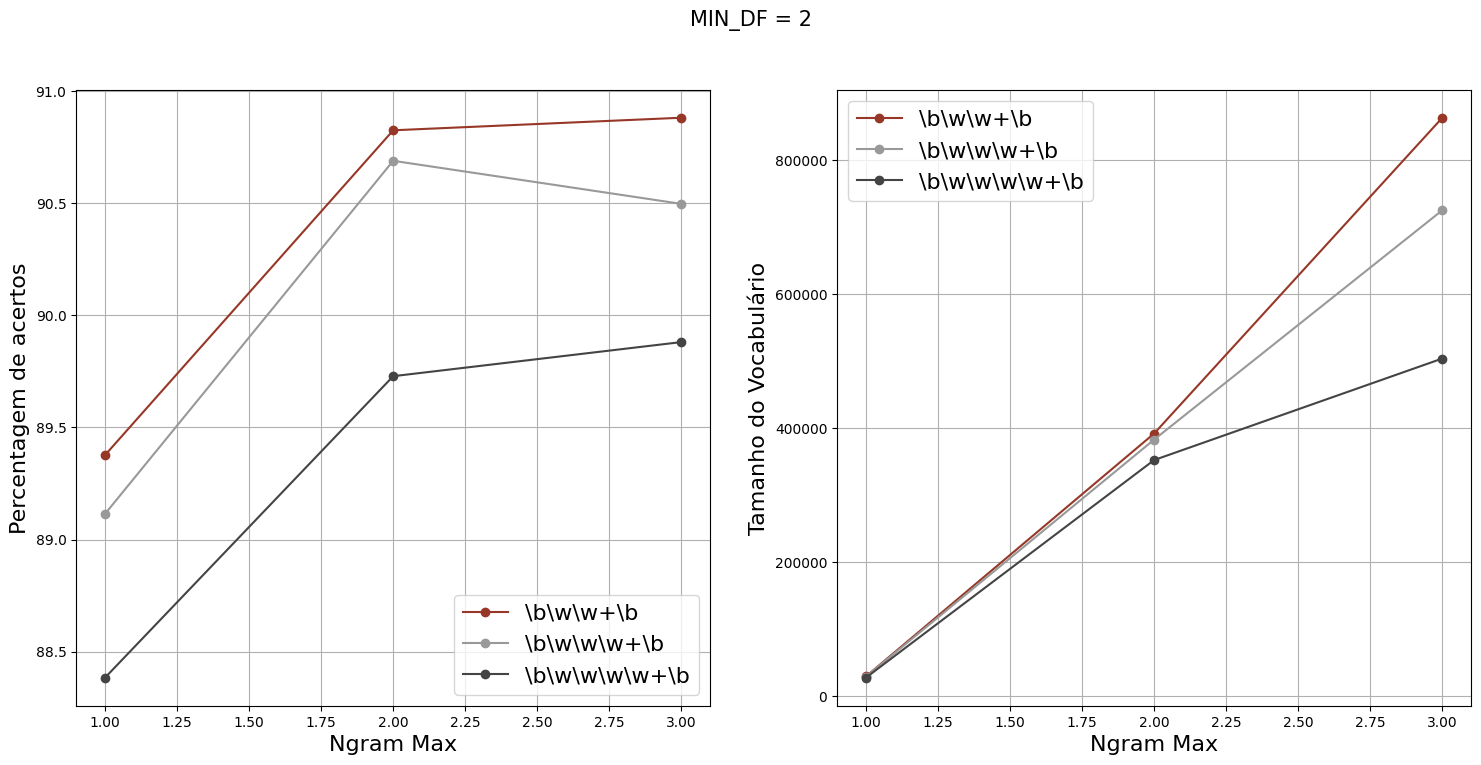

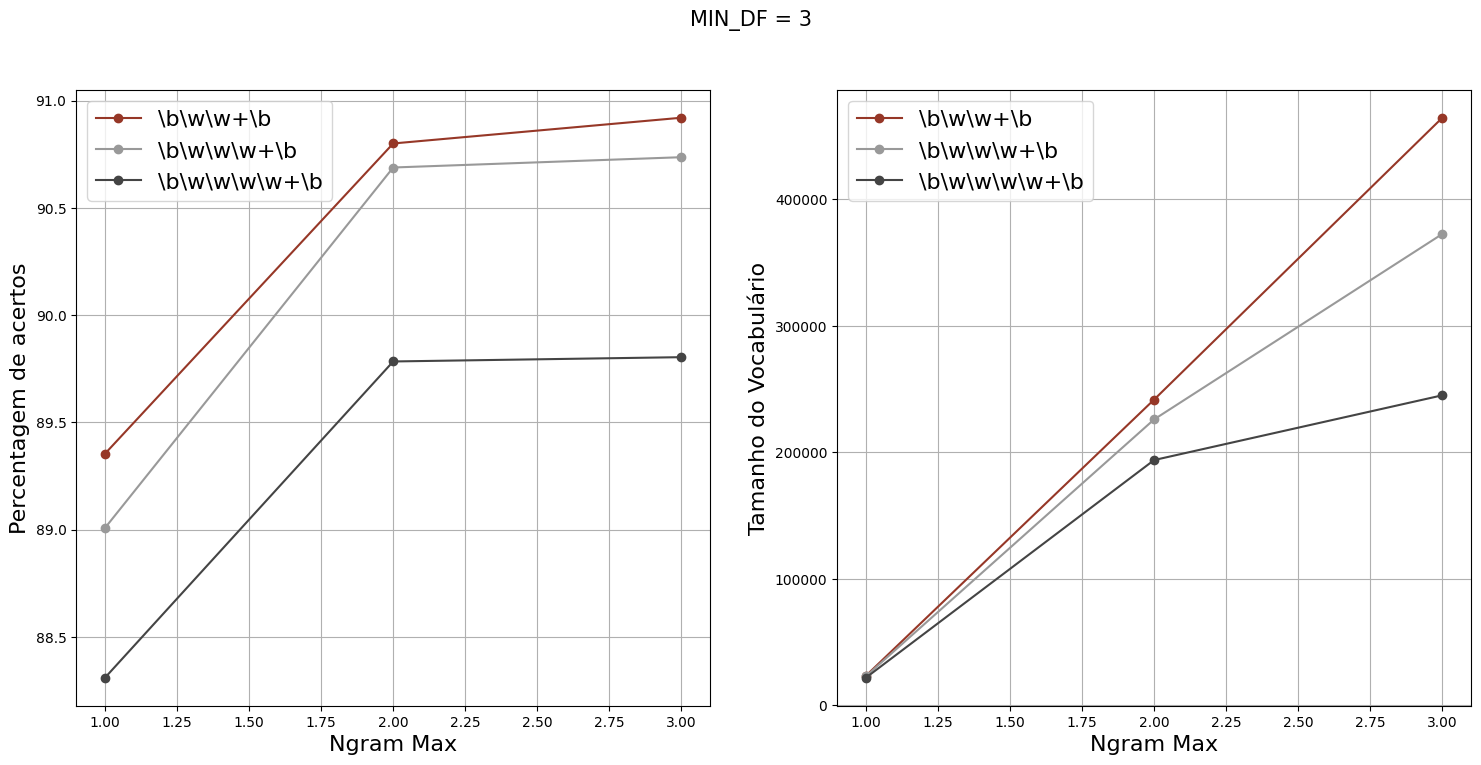

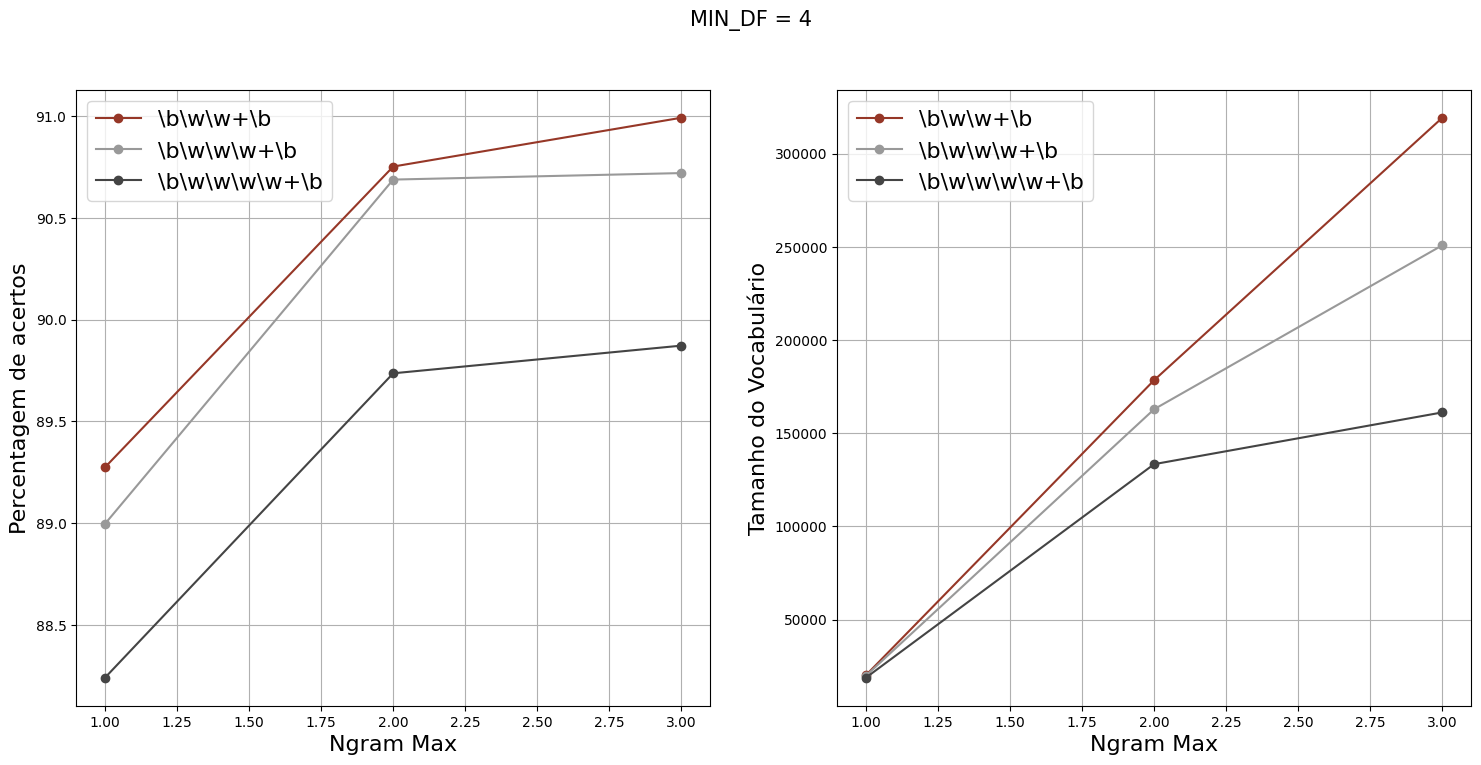

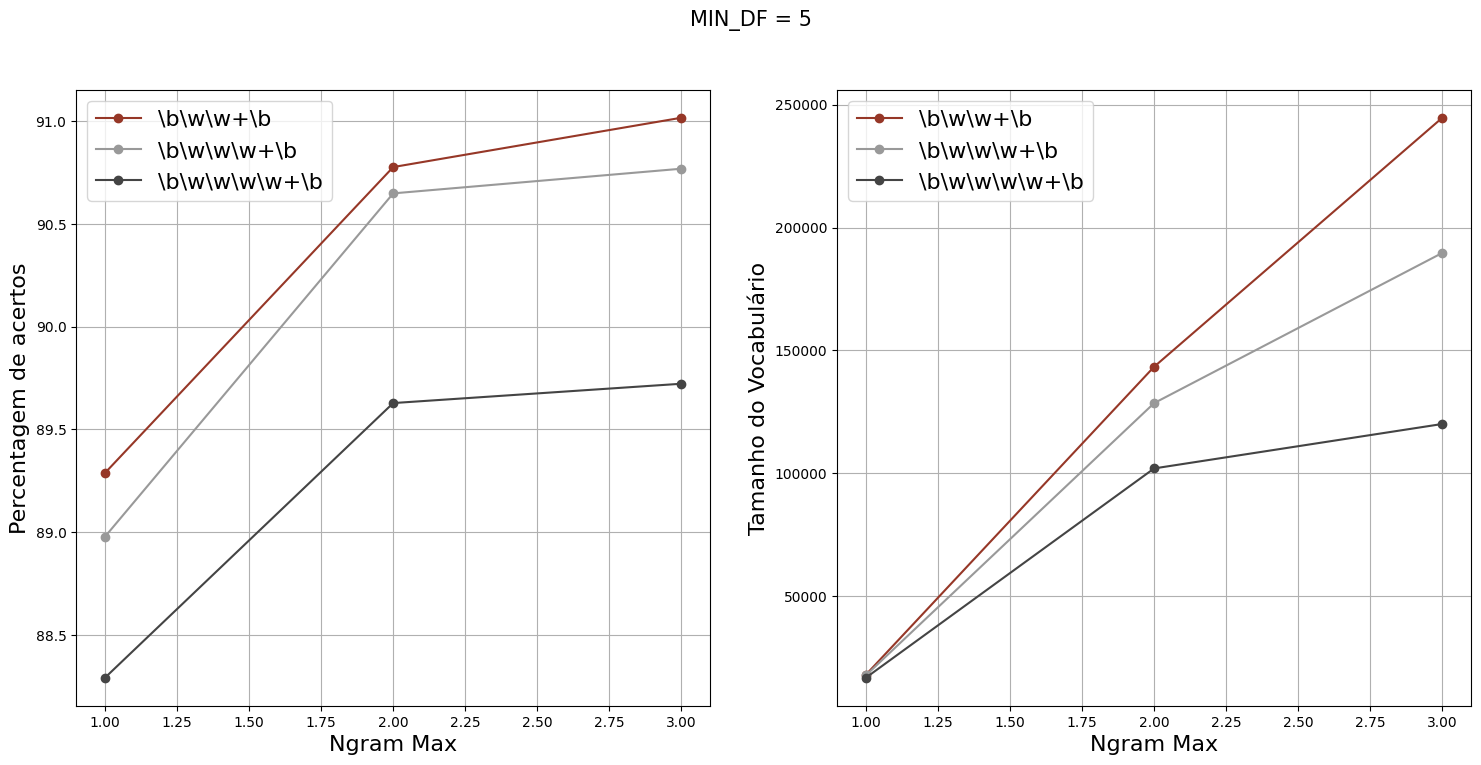

In [13]:
#2
plt.figure(figsize=(18,8))
plt.subplot(1,2,1)
plt.suptitle('MIN_DF = 2',  fontsize=15)
plt.plot([1,2,3],score_2[0], '-o', color='#963727')
plt.plot([1,2,3],score_2[1], '-o', color='#999999')
plt.plot([1,2,3],score_2[2], '-o', color='#444444')
plt.xlabel('Ngram Max', fontsize=16)
plt.ylabel('Percentagem de acertos', fontsize=16)
plt.legend((r'\b\w\w+\b', r'\b\w\w\w+\b', r'\b\w\w\w\w+\b'), fontsize=16)
plt.grid()

plt.subplot(1,2,2)
plt.plot([1,2,3], voc_size_2[0], '-o', color='#963727')
plt.plot([1,2,3], voc_size_2[1], '-o', color='#999999')
plt.plot([1,2,3], voc_size_2[2], '-o', color='#444444')
plt.xlabel('Ngram Max', fontsize=16)
plt.ylabel('Tamanho do Vocabulário', fontsize=16)
plt.legend((r'\b\w\w+\b', r'\b\w\w\w+\b', r'\b\w\w\w\w+\b'), fontsize=16)
plt.grid()
plt.show()

#3
plt.figure(figsize=(18,8))
plt.subplot(1,2,1)
plt.suptitle('MIN_DF = 3',  fontsize=15)
plt.plot([1,2,3],score_3[0], '-o', color='#963727')
plt.plot([1,2,3],score_3[1], '-o', color='#999999')
plt.plot([1,2,3],score_3[2], '-o', color='#444444')
plt.xlabel('Ngram Max', fontsize=16)
plt.ylabel('Percentagem de acertos', fontsize=16)
plt.legend((r'\b\w\w+\b', r'\b\w\w\w+\b', r'\b\w\w\w\w+\b'), fontsize=16)
plt.grid()

plt.subplot(1,2,2)
plt.plot([1,2,3], voc_size_3[0], '-o', color='#963727')
plt.plot([1,2,3], voc_size_3[1], '-o', color='#999999')
plt.plot([1,2,3], voc_size_3[2], '-o', color='#444444')
plt.xlabel('Ngram Max', fontsize=16)
plt.ylabel('Tamanho do Vocabulário', fontsize=16)
plt.legend((r'\b\w\w+\b', r'\b\w\w\w+\b', r'\b\w\w\w\w+\b'), fontsize=16)
plt.grid()
plt.show()

#4
plt.figure(figsize=(18,8))
plt.subplot(1,2,1)
plt.suptitle('MIN_DF = 4',  fontsize=15)
plt.plot([1,2,3],score_4[0], '-o', color='#963727')
plt.plot([1,2,3],score_4[1], '-o', color='#999999')
plt.plot([1,2,3],score_4[2], '-o', color='#444444')
plt.xlabel('Ngram Max', fontsize=16)
plt.ylabel('Percentagem de acertos', fontsize=16)
plt.legend((r'\b\w\w+\b', r'\b\w\w\w+\b', r'\b\w\w\w\w+\b'), fontsize=16)
plt.grid()

plt.subplot(1,2,2)
plt.plot([1,2,3], voc_size_4[0], '-o', color='#963727')
plt.plot([1,2,3], voc_size_4[1], '-o', color='#999999')
plt.plot([1,2,3], voc_size_4[2], '-o', color='#444444')
plt.xlabel('Ngram Max', fontsize=16)
plt.ylabel('Tamanho do Vocabulário', fontsize=16)
plt.legend((r'\b\w\w+\b', r'\b\w\w\w+\b', r'\b\w\w\w\w+\b'), fontsize=16)
plt.grid()
plt.show()

#5
plt.figure(figsize=(18,8))
plt.subplot(1,2,1)
plt.suptitle('MIN_DF = 5',  fontsize=15)
plt.plot([1,2,3],score_5[0], '-o', color='#963727')
plt.plot([1,2,3],score_5[1], '-o', color='#999999')
plt.plot([1,2,3],score_5[2], '-o', color='#444444')
plt.xlabel('Ngram Max', fontsize=16)
plt.ylabel('Percentagem de acertos', fontsize=16)
plt.legend((r'\b\w\w+\b', r'\b\w\w\w+\b', r'\b\w\w\w\w+\b'), fontsize=16)
plt.grid()

plt.subplot(1,2,2)
plt.plot([1,2,3], voc_size_5[0], '-o', color='#963727')
plt.plot([1,2,3], voc_size_5[1], '-o', color='#999999')
plt.plot([1,2,3], voc_size_5[2], '-o', color='#444444')
plt.xlabel('Ngram Max', fontsize=16)
plt.ylabel('Tamanho do Vocabulário', fontsize=16)
plt.legend((r'\b\w\w+\b', r'\b\w\w\w+\b', r'\b\w\w\w\w+\b'), fontsize=16)
plt.grid()
plt.show()



## Encontrar melhores C e penaltys



#### Carregar dados e dividi los para caso binario

In [14]:
#vetorizar texto com min_df, token_patern e ngram já descobertos
D = pickle.load(open(stemmed_data_path, 'rb'))
Docs = D['Docs']
y = D['y']

#caso binário
yB = y.copy()
yB[yB < 5] = 0
yB[yB > 6] = 1

Docs1, Docs2, y1, y2     = tts(Docs, yB, test_size=1/4, stratify=yB,random_state=42)
Docs1t, Docs1v, y1t, y1v = tts(Docs1, y1, test_size=1/3, stratify=y1,random_state=42)


#### Vetorizar com parametros optimais obtidos a partir da analise dos graficos

In [15]:
tfidf = TfidfVectorizer(min_df=5, token_pattern=r'\b\w\w+\b', ngram_range=(1,2)).fit(Docs1t)
X1t, X1v = tfidf.transform(Docs1t), tfidf.transform(Docs1v)

cs = np.arange(0.5, 5, 0.5)
ps = ['l1', 'l2']

combinacoes_c_p_bin     = [(p, c) for p in ps for c in cs]

resultados_c_p_bin = []

for p, c in combinacoes_c_p_bin:
    lr = LogisticRegression(penalty=p, solver='liblinear', C=c, max_iter=5000, tol=1e-2)
    lr.fit(X1t, y1t)
    resultados_c_p_bin.append(lr.score(X1v, y1v))

### Guardar resultados em pickle

In [16]:
lr_r_c_p_bin = 'Resultados/lr_r_c_p_bin.p'

In [17]:
dict_results_bin = {'parametros' : combinacoes_c_p_bin, 
                    'scores'   : resultados_c_p_bin
                   }

pickle.dump(dict_results_bin, open(lr_r_c_p_bin, 'wb'))

### Carregar resultados de pickle e análise

In [18]:
best_c_p = pickle.load(open(lr_r_c_p_bin, 'rb'))

combinacoes_c_p = best_c_p["parametros"]

resultados_c_p_bin = best_c_p["scores"]

In [19]:
def annot_max(x,y,z,ax=None):
    xmax = x[np.argmax(y)]
    ymax = np.max(y)
    zmax = z[np.argmax(y)]
    text= "C= " + str(zmax[1]) + " penalty= " + zmax[0]
    if not ax:
        ax=plt.gca()
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    arrowprops=dict(arrowstyle="->",connectionstyle="angle,angleA=0,angleB=60")
    kw = dict(xycoords='data',textcoords="axes fraction",
              arrowprops=arrowprops, bbox=bbox_props, ha="right", va="top")
    ax.annotate(text, xy=(xmax, ymax), xytext=(0.94,0.86), **kw)

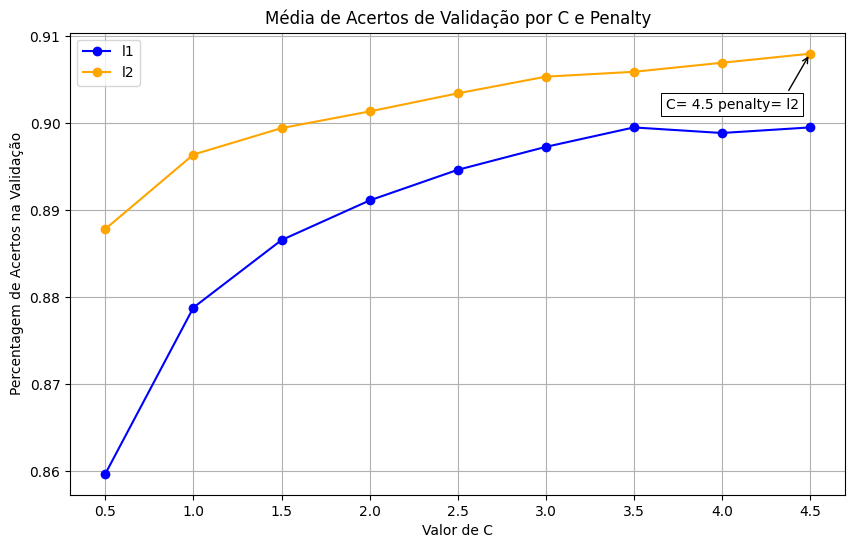

In [20]:

cs = np.arange(0.5, 5, 0.5)

plt.figure(figsize=(10,6))
plt.plot(cs, resultados_c_p_bin[0:9],  '-o', color = 'blue')
plt.plot(cs, resultados_c_p_bin[9:18], '-o', color= 'orange')
annot_max(cs,resultados_c_p_bin[9:18],combinacoes_c_p[9:18])
plt.title('Média de Acertos de Validação por C e Penalty')
plt.xlabel('Valor de C')
plt.ylabel('Percentagem de Acertos na Validação')
plt.legend(('l1', 'l2'))
plt.grid()    

## Testar melhores resultados
#### C: 4.5
#### Penalty: l2

In [21]:
best_pars = [(5),              #min_df
             (r'\b\w\w+\b'),   #token
             ((1,2)),          #ngram
             ('l2'),           #penalty
             (4.5)]            #C    

#### Recarregar dados

In [22]:
D = pickle.load(open(stemmed_data_path, 'rb'))

Docs, y = D['Docs'], D['y']
yB = y.copy()

yB[yB < 5] = 0
yB[yB > 6] = 1

#### vetorizar e treinar modelo com melhores parametros obtidos (dados divididos tts)

In [23]:
lr_model_bin = 'Modelos/lr_model_bin.p'

In [24]:
# Dividir - Estes dados serão reutilizados nos próximos classificadores binários
Docs1_b, Docs2_b, y1_b, y2_b     = tts(Docs, yB, test_size=1/4, stratify=yB, random_state=42)
Docs1t_b, Docs1v_b, y1t_b, y1v_b = tts(Docs1_b, y1_b, test_size=1/3, stratify=y1_b, random_state=42)

# Vetorização
tfidf_bin  = TfidfVectorizer(min_df=best_pars[0], token_pattern=best_pars[1], ngram_range=best_pars[2]).fit(Docs1t_b)

X1t_b = tfidf_bin.transform(Docs1t_b)
X1v_b = tfidf_bin.transform(Docs1v_b)
X2_b  = tfidf_bin.transform(Docs2_b)

# Regressão Logística
lr_bin = LogisticRegression(penalty=best_pars[3], solver='liblinear', C=best_pars[4], max_iter=5000, tol=1e-2,random_state=42)
lr_bin.fit(X1t_b, y1t_b)

pickle.dump({'tfidf' : tfidf}, open(final_tfidf_bin, 'wb'))
pickle.dump({'logReg': lr_bin}, open(lr_model_bin, 'wb'))

In [25]:
# Resultados
print('Tamanho Vocabulário:', len(tfidf_bin.get_feature_names_out()))
print('Score Treino:', lr_bin.score(X1t_b, y1t_b)*100)
print('Score Validação:', lr_bin.score(X1v_b, y1v_b)*100)
print('Score Teste: ', lr_bin.score(X2_b, y2_b)*100)

Tamanho Vocabulário: 143323
Score Treino: 98.86399999999999
Score Validação: 90.8
Score Teste:  90.928


Número de Erros Teste:  1134
Matriz de Confusão Teste:



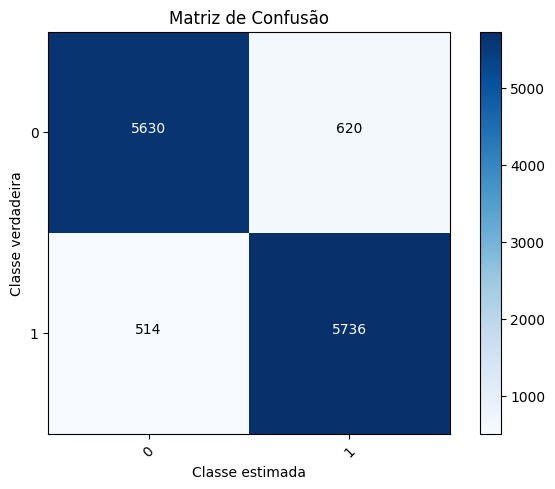

In [26]:
#Matriz Confusão Dados de Teste
print('Número de Erros Teste: ', np.sum(y2_b != lr_bin.predict(X2_b)))
MC = confusion_matrix(y2_b, lr_bin.predict(X2_b))
print('Matriz de Confusão Teste:')
plotMatriz(MC)
print()

Número de Erros Validação:  1150
Matriz de Confusão Validação:


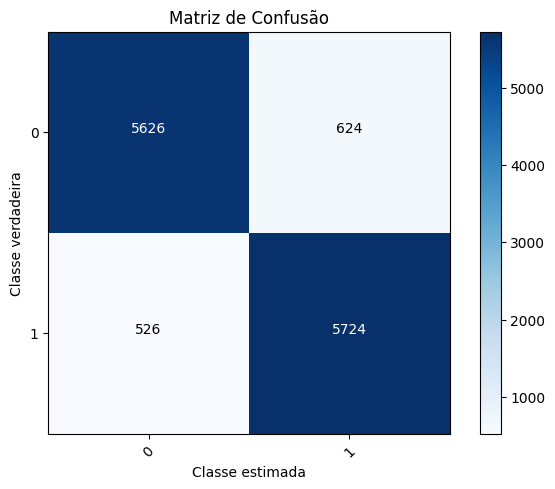

In [27]:
#Matriz de Confusão Dados de Validação
print('Número de Erros Validação: ', np.sum(y1v_b != lr_bin.predict(X1v_b)))
MCV = confusion_matrix(y1v_b, lr_bin.predict(X1v_b))
print('Matriz de Confusão Validação:')
plotMatriz(MCV)

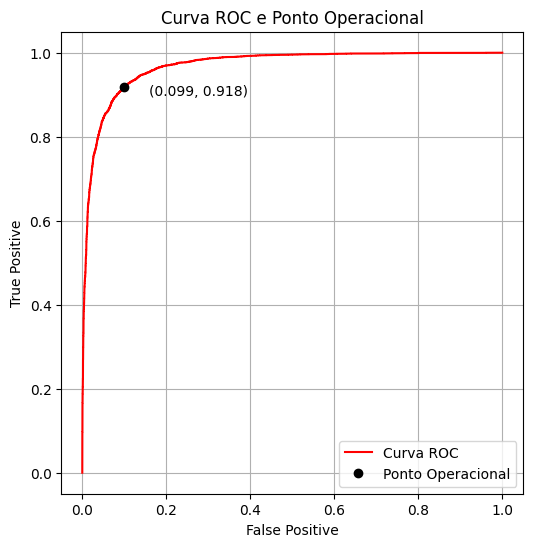

In [28]:
#Curva ROC
fpr, tpr, t = roc_curve(y2_b, lr_bin.decision_function(X2_b))

# Pontos Classificação 
p1 = MC[0,1]/(MC[0,1] + MC[0,0])
p2 = MC[1,1]/(MC[1,1] + MC[1,0])

# Mostrar resultados...
plt.figure(figsize=(6,6))

# Plot da Curva ROC
plt.plot(fpr,tpr, color='red', label='Curva ROC')

# Plot dos Pontos
plt.plot(p1, p2, 'o', color='black', label='Ponto Operacional')
plt.title('Curva ROC e Ponto Operacional')
plt.ylabel('True Positive')
plt.xlabel('False Positive')
plt.legend()
plt.text(p1+0.06, p2-0.02, '(' + str(np.round(p1,3)) + ', ' + str(np.round(p2,3)) + ')' )
plt.axis('scaled')
plt.grid()
plt.show()

In [29]:
D = pickle.load(open(stemmed_data_path, 'rb'))

Docs_test_bin, target_test_bin = D['Docs'], D['y']

y_test_bin = target_test_bin.copy()
y_test_bin[y_test_bin < 5] = 0
y_test_bin[y_test_bin > 6] = 1

X_test_bin  = text2vector(Docs_test_bin, 'b', final_tfidf_bin)
ye_test_bin = binClassify(X_test_bin, 'logReg', False, lr_model_bin)

MC  = confusion_matrix(y_test_bin, ye_test_bin)

print('Matriz de Confusão:')
print(MC)
print('\nNúmero de Erros: ', np.sum(y_test_bin != ye_test_bin))


Matriz de Confusão:
[[23615  1385]
 [ 1183 23817]]

Número de Erros:  2568


## Caso Multi

In [30]:
tfidf_multi_path     = 'tfidf/tfidf_multi.p'
final_tfidf_multi    = 'tfidf/tfidf_multiclasse.p' 

In [31]:
def multi(patterns, min_df, ngram_range):
    D = pickle.load(open(stemmed_data_path, 'rb'))
    Docs = D['Docs']
    y = D['y']
    
    #train test split
    Docs1, Docs2, y1, y2 = tts(Docs, y, test_size=1/4, stratify=y,random_state=42) # 1/4 dos dados totais para teste
    Docs1train, Docs1val, y1train, y1val = tts(Docs1, y1, test_size=1/3, stratify=y1,random_state=42) # dados de validação
    
    #vetorizar texto
    tfidf = TfidfVectorizer(min_df = min_df, token_pattern=patterns, ngram_range=ngram_range).fit(Docs1train)

    #criação do dicionário
    TF_model = {'tfidf' : tfidf}

    #dump dos dados
    pickle.dump(TF_model, open(tfidf_multi_path, 'wb'))
    
    #load dos dados
    tfidf = pickle.load(open(tfidf_multi_path, 'rb'))['tfidf']

    tokens = tfidf.get_feature_names()
    dicionario_size = len(tokens)
    
    X1      = tfidf.transform(Docs1)
    X1train = tfidf.transform(Docs1train)
    X1val   = tfidf.transform(Docs1val)
    X2      = tfidf.transform(Docs2)

    array_cs = [0.01, 0.1, 1, 5, 10]
    array_ps = ['l1', 'l2'] # l1 -> Lasso, l2 -> Ridge
    
    bestScore   = 0
    bestCV = 0 # sobreaprendizagem
    
    par   = None
    parB  = None
    parC  = None
    parD  = None

    ideal = np.array([[1.0], [1.0]])
    dist_min = 1
    ponto    = None
    
    nErros_min = 50000 # número de erros minimo

    for p in array_ps:
        for c in array_cs:
            # com cross validation no conjunto de treino
            logReg = LogisticRegression(penalty=p, solver='saga', C=c, max_iter=5000, tol=1e-2, multi_class='multinomial',random_state=42)
            
            # semelhante ao score mas olhando para o número absoluto de erros
            logReg.fit(X1train, y1train)
            y1valE  = logReg.predict(X1val)
            num_erros = np.sum(y1val!=y1valE)
            
            # tendo em conta a descrepância entre os resultados no treino e na validação
            scoreVal   = logReg.score(X1val, y1val)
            
            if num_erros <= nErros_min:
                nErros_min = num_erros
                parC = (p, c)
            if scoreVal >= bestCV:
                bestCV = scoreVal
                parD = (p, c)
        
    score1 = results_scores('Melhor Score',X1train, X1val, X2, y1train, y1val, y2, dicionario_size, parD)
    score2 = results_scores('Menor número de erros',X1train, X1val, X2, y1train, y1val, y2, dicionario_size, parC)
    
    scoreAvg = np.mean(np.array([score1, score2]))
    print('Final Score ', round(scoreAvg,3))
    print('Dictionary size ', dicionario_size)
    return scoreAvg, dicionario_size

In [32]:
patterns     = [r'\b\w\w+\b', r'\b\w\w\w+\b', r'\b\w\w\w\w+\b'] 
min_dfs      = [2,3,4,5]
ngram_ranges = [(1,1), (1,2), (1,3)]

In [33]:
iniciar = time.time()

combinacoes = [(tp, df, gram) for tp in patterns for df in min_dfs  for gram in ngram_ranges]
resultados  = [multi(tp, df, gram)  for (tp, df, gram)  in combinacoes]

acabar = time.time()

C:\Users\amvlf\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Final Score  43.088
Dictionary size  29293


C:\Users\amvlf\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Final Score  43.392
Dictionary size  390713


C:\Users\amvlf\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Final Score  44.336
Dictionary size  859806


C:\Users\amvlf\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Final Score  43.032
Dictionary size  23264


C:\Users\amvlf\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Final Score  43.576
Dictionary size  240698


C:\Users\amvlf\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Final Score  44.088
Dictionary size  462157


C:\Users\amvlf\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Final Score  43.048
Dictionary size  20065


C:\Users\amvlf\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Final Score  43.48
Dictionary size  178061


C:\Users\amvlf\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Final Score  44.048
Dictionary size  318479


C:\Users\amvlf\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Final Score  43.064
Dictionary size  17952


C:\Users\amvlf\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Final Score  43.384
Dictionary size  142870


C:\Users\amvlf\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Final Score  43.944
Dictionary size  243901


C:\Users\amvlf\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Final Score  42.96
Dictionary size  28899


C:\Users\amvlf\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Final Score  43.52
Dictionary size  381804


C:\Users\amvlf\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Final Score  43.856
Dictionary size  721745


C:\Users\amvlf\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Final Score  43.064
Dictionary size  22939


C:\Users\amvlf\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Final Score  43.696
Dictionary size  225165


C:\Users\amvlf\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Final Score  43.48
Dictionary size  370865


C:\Users\amvlf\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Final Score  42.992
Dictionary size  19782


C:\Users\amvlf\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Final Score  43.528
Dictionary size  162829


C:\Users\amvlf\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Final Score  43.552
Dictionary size  250626


C:\Users\amvlf\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Final Score  42.896
Dictionary size  17698


C:\Users\amvlf\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Final Score  43.568
Dictionary size  128551


C:\Users\amvlf\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Final Score  43.672
Dictionary size  189554


C:\Users\amvlf\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Final Score  42.04
Dictionary size  27440


C:\Users\amvlf\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Final Score  42.376
Dictionary size  351898


C:\Users\amvlf\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Final Score  42.48
Dictionary size  500821


C:\Users\amvlf\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Final Score  42.136
Dictionary size  21731


C:\Users\amvlf\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Final Score  42.664
Dictionary size  192824


C:\Users\amvlf\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Final Score  42.712
Dictionary size  243694


C:\Users\amvlf\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Final Score  42.064
Dictionary size  18722


C:\Users\amvlf\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Final Score  42.808
Dictionary size  132980


C:\Users\amvlf\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Final Score  42.928
Dictionary size  160700


C:\Users\amvlf\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Final Score  41.992
Dictionary size  16747


C:\Users\amvlf\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Final Score  42.96
Dictionary size  101639


C:\Users\amvlf\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Final Score  43.056
Dictionary size  119712


In [34]:
lr_r_tp_ngram_multi = 'Resultados/lr_r_tp_ngram_multi.p'

In [35]:
print('Duração do teste:', int((acabar-iniciar)//60), 'min :', int((acabar-iniciar)%60), 'seg')

score = [i[0] for i in resultados]
dicionario_size = [i[1] for i in resultados]

lido  = {'parametros': combinacoes,'vocabulario': dicionario_size,'score': score}

pickle.dump(lido, open(lr_r_tp_ngram_multi, 'wb'))

Duração do teste: 291 min : 23 seg


In [36]:
dados = pickle.load(open(lr_r_tp_ngram_multi,'rb'))

combinacoes = dados['parametros']
voc_size    = dados['vocabulario']
score       = dados['score']

In [37]:
indices_2 = sort_array(combinacoes,2)
combinacoes_2 = np.array([combinacoes[i] for i in indices_2])
voc_size_2 = np.array([voc_size[i] for i in indices_2]).reshape((3,3))
score_2 = np.array([score[i] for i in indices_2]).reshape((3,3))

indices_3 = sort_array(combinacoes,3)
combinacoes_3 = np.array([combinacoes[i] for i in indices_3])
voc_size_3 = np.array([voc_size[i] for i in indices_3]).reshape((3,3))
score_3 = np.array([score[i] for i in indices_3]).reshape((3,3))

indices_4 = sort_array(combinacoes,4)
combinacoes_4 = np.array([combinacoes[i] for i in indices_4])
voc_size_4 = np.array([voc_size[i] for i in indices_4]).reshape((3,3))
score_4 = np.array([score[i] for i in indices_4]).reshape((3,3))

indices_5 = sort_array(combinacoes,5)
combinacoes_5 = np.array([combinacoes[i] for i in indices_5])
voc_size_5 = np.array([voc_size[i] for i in indices_5]).reshape((3,3))
score_5 = np.array([score[i] for i in indices_5]).reshape((3,3))


C:\Users\amvlf\AppData\Local\Temp\ipykernel_9592\1568842932.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  combinacoes_2 = np.array([combinacoes[i] for i in indices_2])
C:\Users\amvlf\AppData\Local\Temp\ipykernel_9592\1568842932.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  combinacoes_3 = np.array([combinacoes[i] for i in indices_3])
C:\Users\amvlf\AppData\Local\Temp\ipykernel_9592\1568842932.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with dif

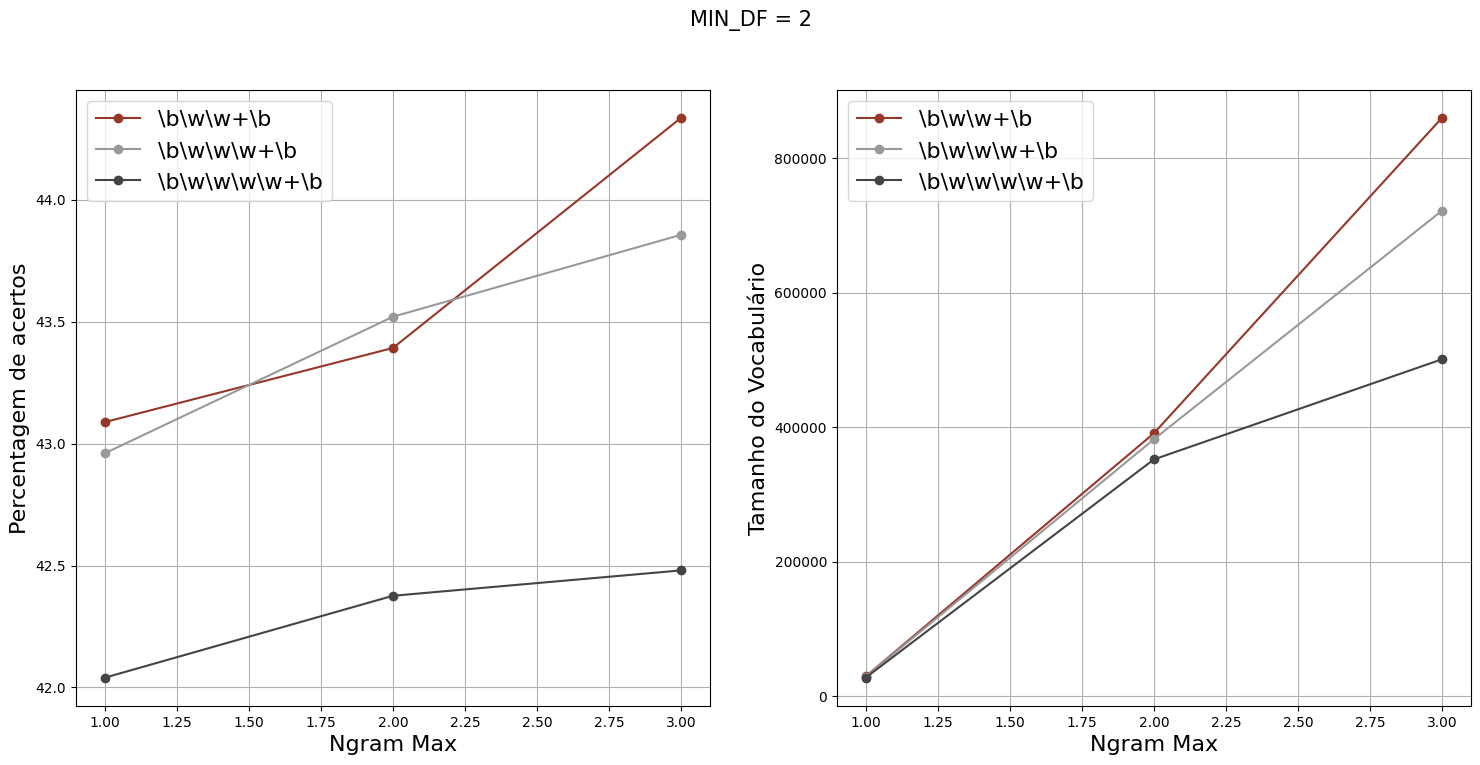

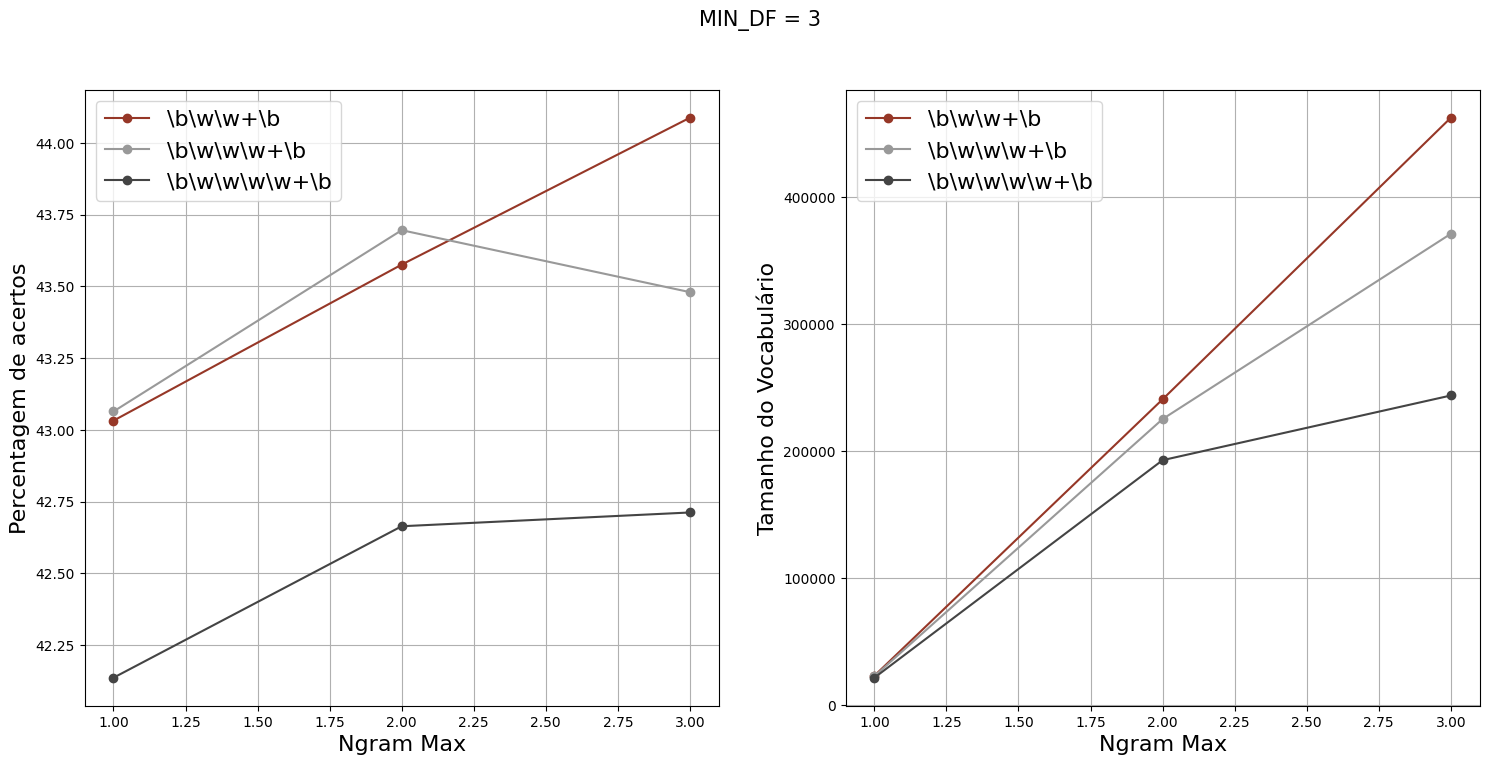

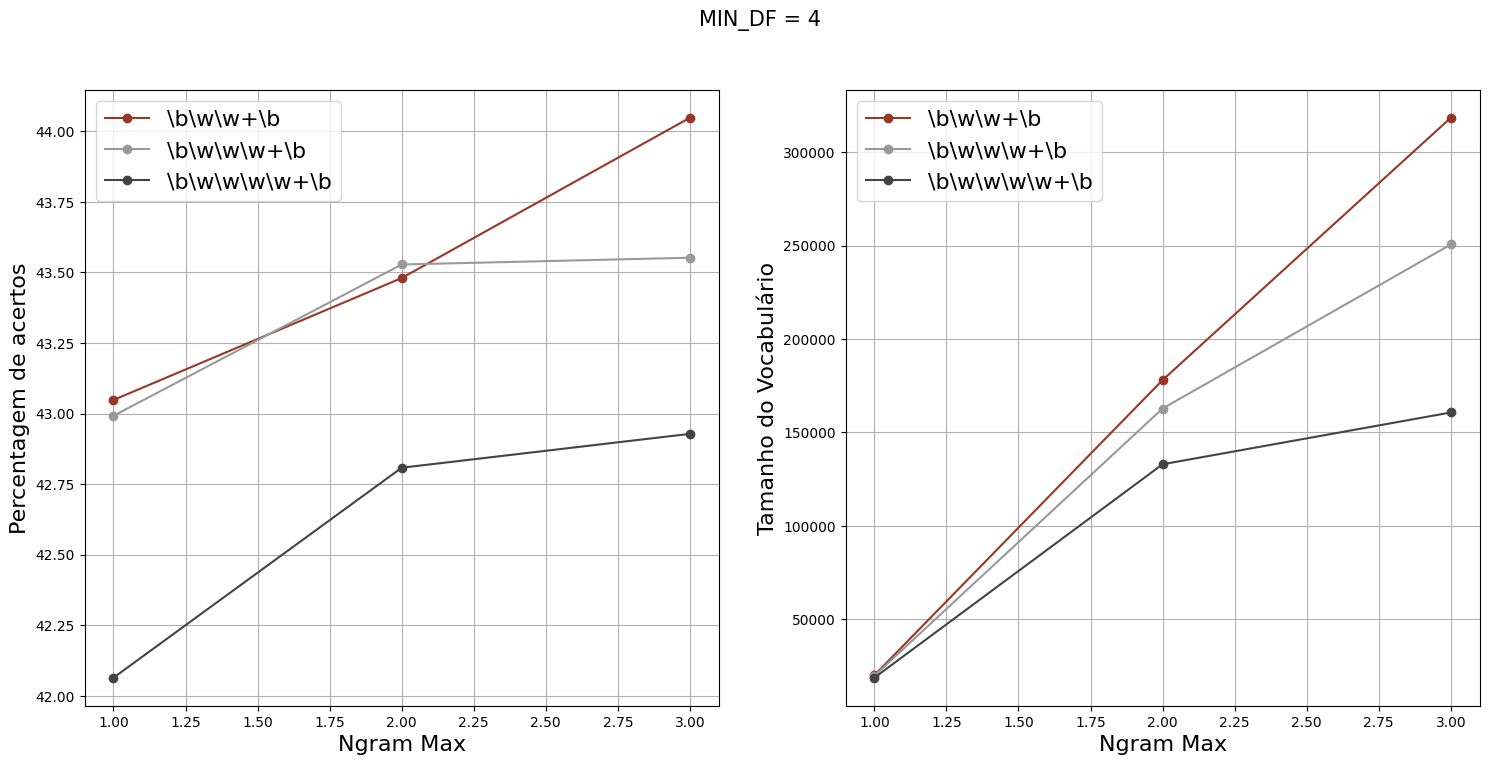

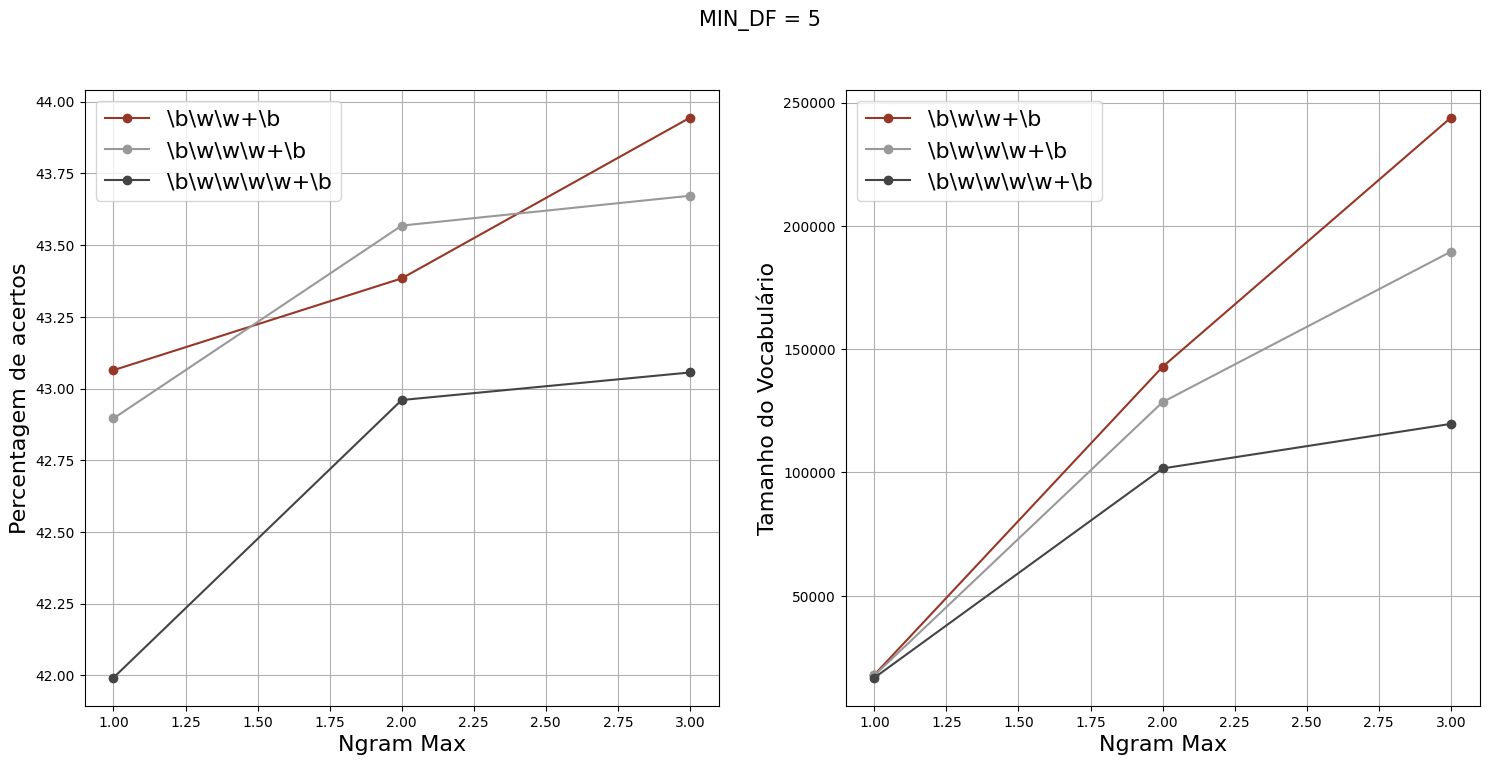

In [38]:
#2
plt.figure(figsize=(18,8))
plt.subplot(1,2,1)
plt.suptitle('MIN_DF = 2',  fontsize=15)
plt.plot([1,2,3],score_2[0], '-o', color='#963727')
plt.plot([1,2,3],score_2[1], '-o', color='#999999')
plt.plot([1,2,3],score_2[2], '-o', color='#444444')
plt.xlabel('Ngram Max', fontsize=16)
plt.ylabel('Percentagem de acertos', fontsize=16)
plt.legend((r'\b\w\w+\b', r'\b\w\w\w+\b', r'\b\w\w\w\w+\b'), fontsize=16)
plt.grid()

plt.subplot(1,2,2)
plt.plot([1,2,3], voc_size_2[0], '-o', color='#963727')
plt.plot([1,2,3], voc_size_2[1], '-o', color='#999999')
plt.plot([1,2,3], voc_size_2[2], '-o', color='#444444')
plt.xlabel('Ngram Max', fontsize=16)
plt.ylabel('Tamanho do Vocabulário', fontsize=16)
plt.legend((r'\b\w\w+\b', r'\b\w\w\w+\b', r'\b\w\w\w\w+\b'), fontsize=16)
plt.grid()
plt.show()

#3
plt.figure(figsize=(18,8))
plt.subplot(1,2,1)
plt.suptitle('MIN_DF = 3',  fontsize=15)
plt.plot([1,2,3],score_3[0], '-o', color='#963727')
plt.plot([1,2,3],score_3[1], '-o', color='#999999')
plt.plot([1,2,3],score_3[2], '-o', color='#444444')
plt.xlabel('Ngram Max', fontsize=16)
plt.ylabel('Percentagem de acertos', fontsize=16)
plt.legend((r'\b\w\w+\b', r'\b\w\w\w+\b', r'\b\w\w\w\w+\b'), fontsize=16)
plt.grid()

plt.subplot(1,2,2)
plt.plot([1,2,3], voc_size_3[0], '-o', color='#963727')
plt.plot([1,2,3], voc_size_3[1], '-o', color='#999999')
plt.plot([1,2,3], voc_size_3[2], '-o', color='#444444')
plt.xlabel('Ngram Max', fontsize=16)
plt.ylabel('Tamanho do Vocabulário', fontsize=16)
plt.legend((r'\b\w\w+\b', r'\b\w\w\w+\b', r'\b\w\w\w\w+\b'), fontsize=16)
plt.grid()
plt.show()

#4
plt.figure(figsize=(18,8))
plt.subplot(1,2,1)
plt.suptitle('MIN_DF = 4',  fontsize=15)
plt.plot([1,2,3],score_4[0], '-o', color='#963727')
plt.plot([1,2,3],score_4[1], '-o', color='#999999')
plt.plot([1,2,3],score_4[2], '-o', color='#444444')
plt.xlabel('Ngram Max', fontsize=16)
plt.ylabel('Percentagem de acertos', fontsize=16)
plt.legend((r'\b\w\w+\b', r'\b\w\w\w+\b', r'\b\w\w\w\w+\b'), fontsize=16)
plt.grid()

plt.subplot(1,2,2)
plt.plot([1,2,3], voc_size_4[0], '-o', color='#963727')
plt.plot([1,2,3], voc_size_4[1], '-o', color='#999999')
plt.plot([1,2,3], voc_size_4[2], '-o', color='#444444')
plt.xlabel('Ngram Max', fontsize=16)
plt.ylabel('Tamanho do Vocabulário', fontsize=16)
plt.legend((r'\b\w\w+\b', r'\b\w\w\w+\b', r'\b\w\w\w\w+\b'), fontsize=16)
plt.grid()
plt.show()

#5
plt.figure(figsize=(18,8))
plt.subplot(1,2,1)
plt.suptitle('MIN_DF = 5',  fontsize=15)
plt.plot([1,2,3],score_5[0], '-o', color='#963727')
plt.plot([1,2,3],score_5[1], '-o', color='#999999')
plt.plot([1,2,3],score_5[2], '-o', color='#444444')
plt.xlabel('Ngram Max', fontsize=16)
plt.ylabel('Percentagem de acertos', fontsize=16)
plt.legend((r'\b\w\w+\b', r'\b\w\w\w+\b', r'\b\w\w\w\w+\b'), fontsize=16)
plt.grid()

plt.subplot(1,2,2)
plt.plot([1,2,3], voc_size_5[0], '-o', color='#963727')
plt.plot([1,2,3], voc_size_5[1], '-o', color='#999999')
plt.plot([1,2,3], voc_size_5[2], '-o', color='#444444')
plt.xlabel('Ngram Max', fontsize=16)
plt.ylabel('Tamanho do Vocabulário', fontsize=16)
plt.legend((r'\b\w\w+\b', r'\b\w\w\w+\b', r'\b\w\w\w\w+\b'), fontsize=16)
plt.grid()
plt.show()


In [39]:
D = pickle.load(open(stemmed_data_path, 'rb'))
Docs = D['Docs']
y = D['y']

Docs1, Docs2, y1, y2     = tts(Docs, y, test_size=1/4, stratify=y,random_state=42)
Docs1t, Docs1v, y1t, y1v = tts(Docs1, y1, test_size=1/3, stratify=y1,random_state=42)

In [40]:
#vetorizar texto com min_df, token_patern e ngram já descobertos
tfidf_multi = TfidfVectorizer(min_df=5, token_pattern=r'\b\w\w\w+\b', ngram_range=(1,2)).fit(Docs1t)
X1t, X1v    = tfidf_multi.transform(Docs1t), tfidf_multi.transform(Docs1v)

cs = np.arange(0.5, 5, 0.5)
ps = ['l1', 'l2']

combinacoes_c_p_multi     = [(p, c) for p in ps for c in cs]

resultados_c_p_multi = []

for p, c in combinacoes_c_p_multi:
    lr_multi = LogisticRegression(penalty=p, solver='saga', C=c, max_iter=5000, tol=1e-2, multi_class='multinomial',random_state=42)
    lr_multi.fit(X1t, y1t)
    resultados_c_p_multi.append(lr_multi.score(X1v, y1v))


In [41]:
lr_r_c_p_multi = 'Resultados/lr_r_c_p_multi.p'

In [42]:
dict_results_multi = {'parametros' : combinacoes_c_p_multi, 
                'scores'   : resultados_c_p_multi
                }

pickle.dump(dict_results_multi, open(lr_r_c_p_multi, 'wb'))

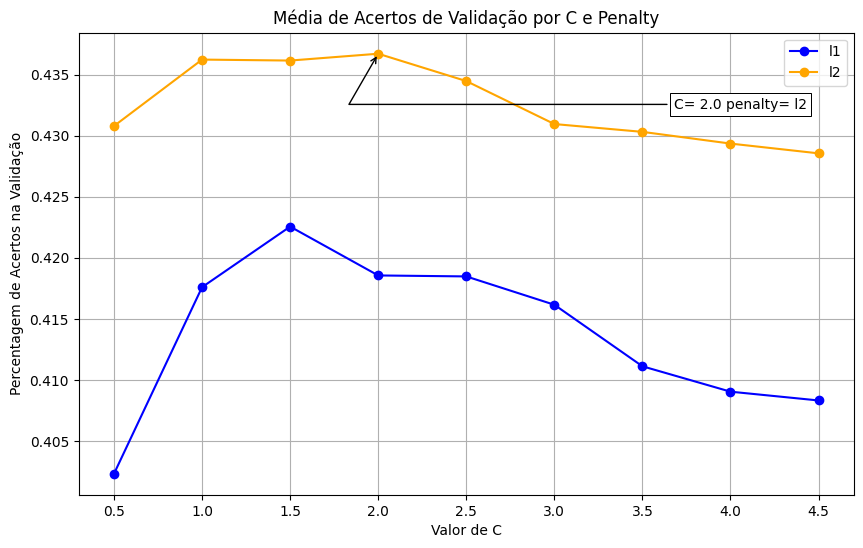

In [43]:
best_c_p_multi = pickle.load(open(lr_r_c_p_multi, 'rb'))

combinacoes_c_p_multi = best_c_p_multi["parametros"]
resultados_c_p_multi = best_c_p_multi["scores"]

cs = np.arange(0.5, 5, 0.5)

plt.figure(figsize=(10,6))
plt.plot(cs, resultados_c_p_multi[0:9],  '-o', color='blue')
plt.plot(cs, resultados_c_p_multi[9:18], '-o', color='orange')
annot_max(cs,resultados_c_p_multi[9:18],combinacoes_c_p_multi[9:18])
plt.title('Média de Acertos de Validação por C e Penalty')
plt.xlabel('Valor de C')
plt.ylabel('Percentagem de Acertos na Validação')
plt.legend(('l1', 'l2'))
plt.grid()    

### Testar melhores resultados 
#### C: 2
#### Penalty: l2

In [44]:
best_pars_m = [(5),              #min_df
             (r'\b\w\w\w+\b'),   #token
             ((1,2)),          #ngram
             ('l2'),           #penalty
             (2)]            #C    

In [45]:
D = pickle.load(open(stemmed_data_path, 'rb'))
Docs = D['Docs']
y = D['y']

Docs_m = Docs.copy()
y_m = y.copy()

Docs1_m, Docs2_m, y1_m, y2_m     = tts(Docs_m, y_m, test_size=1/4, stratify=y_m,random_state=42)
Docs1t_m, Docs1v_m, y1t_m, y1v_m = tts(Docs1_m, y1_m, test_size=1/3, stratify=y1_m,random_state=42)

In [46]:
# Vetorização
tfidf_multi  = TfidfVectorizer(min_df=best_pars_m[0], token_pattern=best_pars_m[1], ngram_range=best_pars_m[2]).fit(Docs1t_m)

X1t_m = tfidf_multi.transform(Docs1t_m)
X1v_m = tfidf_multi.transform(Docs1v_m)
X2_m  = tfidf_multi.transform(Docs2_m)

# Regressão Logística
lr_multi = LogisticRegression(penalty=best_pars_m[3], solver='saga', C=best_pars_m[4], max_iter=5000, tol=1e-2, multi_class='multinomial',random_state=42)
lr_multi.fit(X1t_m, y1t_m)

lr_model_multi = 'Modelos/lr_model_multi.p'

pickle.dump({'tfidf' : tfidf_multi}, open(final_tfidf_multi, 'wb'))
pickle.dump({'logReg' : lr_multi}, open(lr_model_multi, 'wb'))

In [47]:
# Resultados
print('Tamanho Vocabulário de treino:', len(tfidf_multi.get_feature_names_out()))
print('Score Treino:', lr_multi.score(X1t_m, y1t_m)*100)
print('Score Validação:', lr_multi.score(X1v_m, y1v_m)*100)
print('Score Teste: ', lr_multi.score(X2_m, y2_m)*100)

Tamanho Vocabulário de treino: 128551
Score Treino: 87.64
Score Validação: 43.616
Score Teste:  43.696


Número de Erros Teste:  7038
Matriz de Confusão Teste:



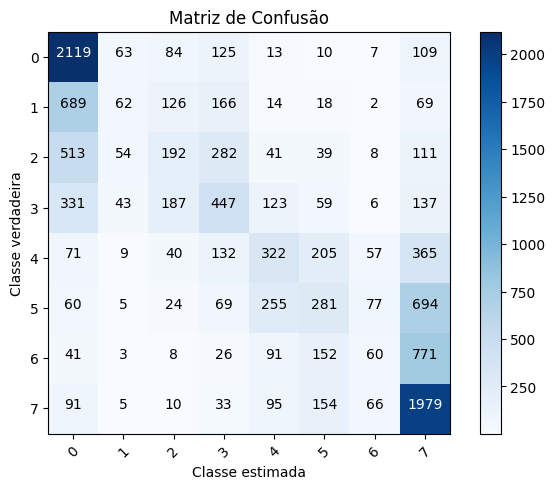

In [48]:
#Matriz Confusão Dados de Teste
print('Número de Erros Teste: ', np.sum(y2_m != lr_multi.predict(X2_m)))
MC = confusion_matrix(y2_m, lr_multi.predict(X2_m))
print('Matriz de Confusão Teste:')
plotMatriz(MC)
print()

Número de Erros Validação:  7048
Matriz de Confusão Validação:


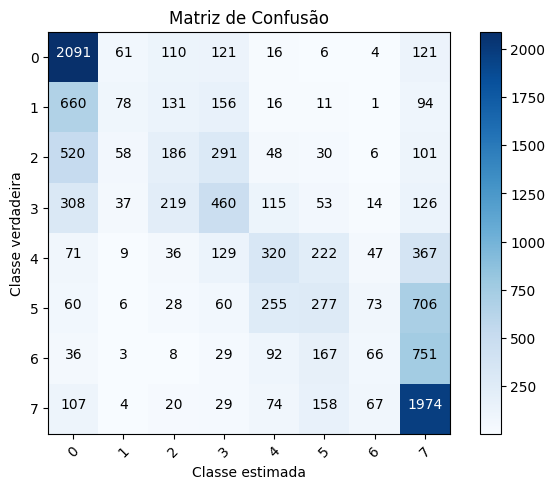

In [49]:
#Matriz de Confusão Dados de Validação
print('Número de Erros Validação: ', np.sum(y1v_m != lr_multi.predict(X1v_m)))
MCV = confusion_matrix(y1v_m, lr_multi.predict(X1v_m))
print('Matriz de Confusão Validação:')
plotMatriz(MCV)

In [50]:
D = pickle.load(open(stemmed_data_path, 'rb'))

Docs_test_mult, y_test_mult = D['Docs'], D['y']

X_test_mult  = text2vector(Docs_test_mult, 'm', final_tfidf_multi)
ye_test_mult = multiClassify(X_test_mult, 'logReg', False, lr_model_multi)

MC  = confusion_matrix(y_test_mult, ye_test_mult)

print('Matriz de Confusão:')
print(MC)
print('\n','Número de Erros: ', np.sum(y_test_mult != ye_test_mult))


Matriz de Confusão:
[[9160  125  207  276   35   25   12  282]
 [1795 1844  267  369   41   35    5  230]
 [1358  116 2408  597  101   73   16  292]
 [ 853   82  407 3255  253  120   21  340]
 [ 204   24   83  281 2654  435  111 1011]
 [ 163   14   62  149  531 2999  155 1786]
 [ 125    9   26   63  222  349 1790 2023]
 [ 234   11   34   76  202  324  136 8714]]

 Número de Erros:  17176
